::: {.callout-note}
Data from the SIB course [Diving into deep learning - theory and applications with PyTorch](https://www.sib.swiss/training/course/20241108_DEEPP).
:::

## Goal
- Implementing a convolutional neural network (CNN) to predict protein subcellular localization relying on sequence information
- Comparing the CNN with the feedforward neural network (FNN)
- Expected output: CNN should provide a performance improvement over FNN

## Dataset information
- The dataset is from https://academic.oup.com/bioinformatics/article/33/21/3387/3931857
- Each sequence is encoded as a matrix where each position is a row of size 20, for each possible amino acid
- The values within the matrix represent the amino acid frequency at the given position

## Loading libraries

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import torch
from torch import nn
import pytorch_model_summary as pms 
from torch.utils.data import TensorDataset, DataLoader

from pytorchtools import EarlyStopping

# get cpu, gpu or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Loading the protein sequences and labels 

In [4]:
## training data
train = np.load('data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
print('train:', X_train.shape)

## validation data
validation = np.load('data/reduced_val.npz')
X_valid = validation['X_val']
y_valid = validation['y_val']
print('valid:', X_valid.shape)

train: (2423, 400, 20)
valid: (635, 400, 20)


## Defining the subcellular localization

In [4]:
classes = ['Nucleus',
           'Cytoplasm',
           'Extracellular',
           'Mitochondrion',
           'Cell membrane',
           'ER',
           'Chloroplast',
           'Golgi apparatus',
           'Lysosome',
           'Vacuole']

dico_classes_subcell={i:v for i,v in enumerate(classes)}
for i in dico_classes_subcell.keys():
    print('Target', i, dico_classes_subcell[i])

Target 0 Nucleus
Target 1 Cytoplasm
Target 2 Extracellular
Target 3 Mitochondrion
Target 4 Cell membrane
Target 5 ER
Target 6 Chloroplast
Target 7 Golgi apparatus
Target 8 Lysosome
Target 9 Vacuole


## Building the data loaders

In [5]:
batch_size = 128

# transform to torch tensor
X_train_tensor = torch.Tensor(X_train) 
y_train_tensor = torch.LongTensor(y_train)

X_valid_tensor = torch.Tensor(X_valid) 
y_valid_tensor = torch.LongTensor(y_valid)

# create the dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) 
valid_dataset = TensorDataset(X_valid_tensor,y_valid_tensor) 

## create the dataloader
train_dataloader = DataLoader(train_dataset, batch_size = batch_size) 
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size)

### Building the convolutional neural network (CNN)

This CNN uses two convolutional layers with a 3x3 kernel and a ReLU activation, followed by max pooling to downsample the sequence length while preserving the feature dimension. The resulting features are flattened and fed into a fully connected layer, which maps the extracted features to the 10 subcellular localizations.

In [6]:
class ProteinLoc_CNN(nn.Module):
    def __init__(self, seq_len=400, n_feat=20, n_class=10, out_channels=10):
        super().__init__()
        
        ## - two 2D (data are 2D (400 x 20)) convolutional layers with:
        ##   - a 3x3 kernel to capture local features
        ##   - a 1x1 padding to preserve spatial dimension (output feature map dimension = input feature map dimension)
        ## - a max pooling with a 5x1 padding to reduce the sequence length by a factor of 5 preserving feature dimension
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(5, 1), stride=(5, 1)),

            nn.Conv2d(in_channels=out_channels, out_channels=out_channels*2, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(5, 1), stride=(5, 1))
        )
        
        ## flatten the layer to transforms the 2D feature maps from the convolutional layers into a 1D vector
        self.flatten = nn.Flatten()
        
        ## fully connected layer
        ## map the features from the convolutional layers to the subcellular localizations
        self.dense_layers = nn.Sequential(
            nn.Linear(out_channels * 2 * (seq_len // (5 * 5)) * n_feat, n_class)
        )
                        
    def forward(self, x):
        ## add a channel to reshape the data in the form (batch_size, 1, 400, 20) and
        ## make them compatible with the Conv2d shape (batch_size, channels, height, width)
        x = x.unsqueeze(1)
        x = self.conv(x)  
        x = self.flatten(x)  
        x = self.dense_layers(x)
        return x

# initialize the model
model = ProteinLoc_CNN(seq_len=400, n_feat=20, n_class=10, out_channels=40).to(device)
print(model)

# check model
x, _ = train_dataset[0]
print(pms.summary(model, x.reshape(1, 400, 20).to(device), show_input=False))

ProteinLoc_CNN(
  (conv): Sequential(
    (0): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(5, 1), stride=(5, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(5, 1), stride=(5, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_layers): Sequential(
    (0): Linear(in_features=25600, out_features=10, bias=True)
  )
)
------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 40, 400, 20]             400             400
            ReLU-2     [1, 40, 400, 20]               0               0
       MaxPool2d-3      [1, 40, 80, 20]               0               0
          Conv2d-4      [1, 80, 80, 20]          28,880          28,880
           

### Building the feedforward neural network (FNN)

Taken from the 2nd notebook of the course

In [7]:
class ProteinLoc_FNN(torch.nn.Module):
    def __init__(self , input_dim = 8000, 
                         hidden_dim = [80],
                         output_dim = 10, 
                         dropout_fraction = 0.25):
        super().__init__()
        
        ## we transform the input from 2D to 1D
        self.flatten = nn.Flatten()
        
        elements = []
        # each layer is made of a linear layer with a ReLu activation and a DropOut Layer
        for i in range(len(hidden_dim)):
            
            elements.append( nn.Linear(input_dim, hidden_dim[i]) )
            elements.append( nn.ReLU() )
            elements.append( nn.Dropout(dropout_fraction) ) ## add regulation
            
            input_dim = hidden_dim[i] ## update the input dimension for the next layer
        
        elements.append( nn.Linear(input_dim, output_dim) )

        self.layers = nn.Sequential( *elements )
        
    def forward(self, x):
        x = self.flatten(x)
        ## NB: here, the output of the last layer are logits
        logits = self.layers(x)
        return logits

# initialize model
model = ProteinLoc_FNN(input_dim=8000, hidden_dim=[80], output_dim=10, dropout_fraction=0.25).to(device)
print(model)

## check model
print(pms.summary(model, torch.zeros(1,400,20).to(device), show_input=True))

ProteinLoc_FNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=8000, out_features=80, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=80, out_features=10, bias=True)
  )
)
-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
         Flatten-1        [1, 400, 20]               0               0
          Linear-2           [1, 8000]         640,080         640,080
            ReLU-3             [1, 80]               0               0
         Dropout-4             [1, 80]               0               0
          Linear-5             [1, 80]             810             810
Total params: 640,890
Trainable params: 640,890
Non-trainable params: 0
-----------------------------------------------------------------------


## Training/validation and plotting functions

In [8]:
def train(dataloader, model, loss_fn, optimizer, echo=True, echo_batch=False):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() # Sets the module in training mode.
    
       
    for batch, (X, y) in enumerate(dataloader): # for each batch
        X, y = X.to(device), y.to(device)       # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, y)      # loss function from these prediction
                
        # Backpropagation
        loss.backward()              # backward propagation 
                                     # https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
                                     # https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        
        if echo_batch:
            current =  (batch + 1) * len(X)
            print(f"Train loss: {loss.item():>7f} [{current:>5d}/{size:>5d}]")
    
    if echo:
        current =  (batch + 1) * len(X)
        print(f"Train loss: {loss.item():>7f}")

    # return the last batch loss
    return loss.item()

def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Sets the module in evaluation mode
        
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()  ## accumulating the loss function over the batches
              
    valid_loss /= num_batches

    if echo:
        print(f"\tValid loss: {valid_loss:>8f}")
   
    return  valid_loss

### Utility functions

In [9]:
## get predicted and target from the model
def get_model_predictions_and_y(model, dataloader):
    target = np.array([], dtype= 'float32') ## []
    predicted = np.array([], dtype= 'float32') ## []
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            pred = model(X)
            target = np.concatenate([target, y.squeeze().numpy()]) ## extend -> concatenate for list
            predicted = np.concatenate([predicted, np.argmax(pred.to('cpu').detach().numpy() , axis=1) ] )

    return predicted, target

## utility function: compute additional metrics during training besides entropy loss 
def get_additional_scores(predicted, target):   
    return { 'balanced_accuracy': metrics.balanced_accuracy_score(target, predicted),
             'accuracy': metrics.accuracy_score(target, predicted),
             'f1': metrics.f1_score(target, predicted, average = 'macro') }

### Plotting functions

In [10]:
## plot training metrics
def plot_model_training(train_scores, valid_scores):
    fig, axes = plt.subplots(2,2,figsize = (14,8))    

    for i,k in enumerate( ['loss', 'balanced_accuracy', 'accuracy', 'f1'] ) :
        axes[i//2][i%2].plot(train_scores[k], label = 'train')
        axes[i//2][i%2].plot(valid_scores[k], label = 'validation')
        if k == 'loss':
            axes[i//2][i%2].axvline(np.argmin(valid_scores[k]), linestyle='--', color='r',label='Early Stopping Checkpoint')
        axes[i//2][i%2].legend()
        axes[i//2][i%2].set_xlabel('epoch')
        axes[i//2][i%2].set_ylabel(k)

## plot confusion matrix
def plot_confusion_matrix(model, X_valid_tensor, y_valid):
    ## we can also use get_model_predictions_and_y() instead 
    y_pred = model(X_valid_tensor.to(device))
    y_pred = np.argmax(y_pred.detach().cpu().numpy(), axis=1)

    df = pd.crosstab(y_valid, y_pred, rownames=['truth'], colnames=['prediction'])
    df.columns = classes
    df.index = classes

    #trick to make the 0s dissapear
    sns.heatmap(df, annot = df.astype(str).replace('0',''), fmt ='s', cmap = 'viridis')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## plotting accuracy
def plot_accuracy(accuracy, xlabel, ylabel='Accuracy', title='Accuracy comparison'):
    plt.figure(figsize=(4,4))
    acc_score = accuracy
    x = np.arange(len(acc_score))
    plt.bar(x, acc_score)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(x, xlabel, rotation=60)
    for i, v in enumerate(acc_score):
        plt.text(i, v-0.07, '%.3f'%v, color='white', fontweight='bold', ha='center')

### Wrapper function

To train and evaluate CNN and FNN we use:

 - [CEloss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) as loss function
 - [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score),      [balanced_accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score) and
   [F1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) as performance metrics
 - [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) as optimizer. For both models we used the hyperparameters configuration adopted from the 2nd notebook
 - [early stopping](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html?highlight=dropout#early-stopping) for regularization

<!-- We train the CNN and FNN using the default hyperparameters of the Adam optimizer ([link](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)) -->

In [11]:
def train_ProteinLoc(model = ProteinLoc_CNN().to(device), 
                     lr=10**-3, weight_decay=0, ## default Adam parameters setting
                     epochs=100, patience=25):
   
    ## set the model
    model = model

    ## set the loss function counting class unbalancing
    n_class=10
    W = torch.Tensor(compute_class_weight(class_weight='balanced', 
                     classes = np.array(list(range(n_class))), ## map subcell locations to int
                     y= y_train)).to(device)
    CEloss = nn.CrossEntropyLoss(weight = W)
    #print('weights_classes',W.cpu().numpy())

    ## set the optimizer: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr =  lr,
                                 weight_decay = weight_decay)

    ## early stopping: prevent overfitting and reduce training time
    early_stopping = EarlyStopping(patience=patience, verbose=False)

    ## keep the scores across epochs
    train_scores = {'loss':[], 'balanced_accuracy':[], 'accuracy':[], 'f1':[]}
    valid_scores = {'loss':[], 'balanced_accuracy':[], 'accuracy':[], 'f1':[]}
    
    ## train the model across epochs
    for t in range(1,epochs+1):
        echo = t%10==0
        if echo:
            print('Epoch',t )    
        
        ## training set
        train_scores['loss'].append(train(train_dataloader, 
                                    model, 
                                    CEloss, 
                                    optimizer,                        
                                    echo=echo, echo_batch=False))
        pred_train, target_train = get_model_predictions_and_y(model, train_dataloader)
        train_metric = get_additional_scores(pred_train, target_train)
        
        ## validation set
        valid_scores['loss'].append(valid(valid_dataloader, 
                                    model, 
                                    CEloss,
                                    echo=echo))
        pred_valid, target_valid = get_model_predictions_and_y(model, valid_dataloader)
        valid_metric = get_additional_scores(pred_valid, target_valid)
        
        ## add extra metric
        for k in ['balanced_accuracy', 'accuracy', 'f1']:
            train_scores[k].append(train_metric[k])
            valid_scores[k].append(valid_metric[k])

        early_stopping(valid_scores['loss'][-1], model) ## send last valid_score to early stop

        if early_stopping.early_stop:
            print("Early stopping")
            break

    print("Done!")
    
    return train_scores, valid_scores, model, CEloss, optimizer

### Hyperparmeters

Hyperparmeters configuration used for training/testing all the models - for a fair comparison

In [ ]:
epochs = 500
lr = 10**-4
weight_decay = 10**-2
patience = 100

## Training the CNN

In [13]:
%%time

train_scores_cnn, valid_scores_cnn, model_cnn, CEloss_cnn, optimizer_cnn = \
    train_ProteinLoc(ProteinLoc_CNN(seq_len=400, n_feat=20, n_class=10, out_channels=40).to(device),
                     lr=lr, weight_decay=weight_decay,
                     epochs=epochs, patience=patience)

Epoch 10
Train loss: 1.278552
	Valid loss: 1.793025
Epoch 20
Train loss: 0.594917
	Valid loss: 1.319517
Epoch 30
Train loss: 0.333948
	Valid loss: 1.085360
Epoch 40
Train loss: 0.238646
	Valid loss: 0.987021
Epoch 50
Train loss: 0.189067
	Valid loss: 0.949180
Epoch 60
Train loss: 0.155821
	Valid loss: 0.940055
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 2 out of 100
EarlyStopping counter: 3 out of 100
EarlyStopping counter: 4 out of 100
EarlyStopping counter: 5 out of 100
EarlyStopping counter: 6 out of 100
EarlyStopping counter: 7 out of 100
EarlyStopping counter: 8 out of 100
EarlyStopping counter: 9 out of 100
Epoch 70
Train loss: 0.132961
	Valid loss: 0.945401
EarlyStopping counter: 10 out of 100
EarlyStopping counter: 11 out of 100
EarlyStopping counter: 12 out of 100
EarlyStopping counter: 13 out of 100
EarlyStopping counter: 14 out of 100
EarlyStopping counter: 15 out of 100
EarlyStopping counter: 16 out of 100
EarlyStopping counter: 17 out of 100
EarlyStopping co

### Evaluating the CNN

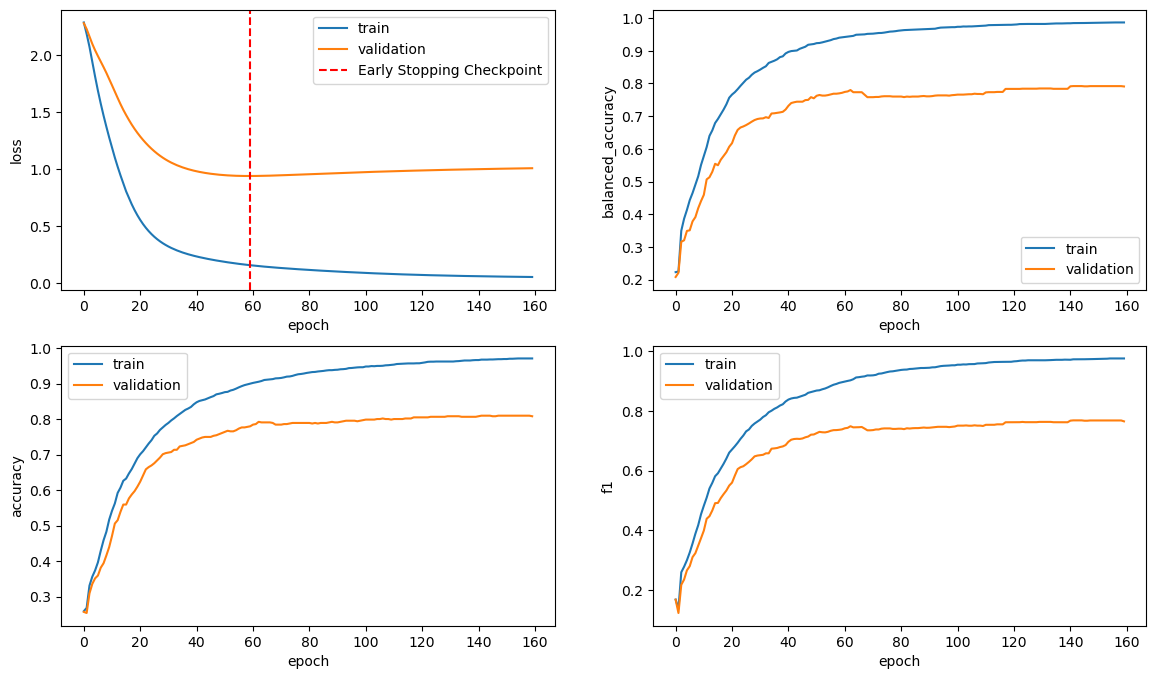

In [14]:
plot_model_training(train_scores_cnn, valid_scores_cnn)

## Training the FNN

In [15]:
%%time 

train_scores_fnn, valid_scores_fnn, model_fnn, CEloss_fnn, optimizer_fnn = \
    train_ProteinLoc(ProteinLoc_FNN(input_dim=8000, hidden_dim=[80], output_dim=10, 
                                    dropout_fraction=0.25).to(device),
                     lr=lr, weight_decay=weight_decay,
                     epochs=epochs, patience=patience)

Epoch 10
Train loss: 1.721765
	Valid loss: 2.017928
Epoch 20
Train loss: 1.237484
	Valid loss: 1.800885
Epoch 30
Train loss: 0.955508
	Valid loss: 1.631265
Epoch 40
Train loss: 0.783767
	Valid loss: 1.508611
Epoch 50
Train loss: 0.655635
	Valid loss: 1.418898
Epoch 60
Train loss: 0.552101
	Valid loss: 1.354256
Epoch 70
Train loss: 0.512112
	Valid loss: 1.313151
EarlyStopping counter: 1 out of 100
Epoch 80
Train loss: 0.434766
	Valid loss: 1.279691
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100
Epoch 90
Train loss: 0.380775
	Valid loss: 1.252143
Epoch 100
Train loss: 0.391283
	Valid loss: 1.230097
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100
Epoch 110
Train loss: 0.368573
	Valid loss: 1.218942
EarlyStopping counter: 2 out of 100
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100
EarlyStopping counter: 1 out of 100
Epoch 120
Train loss: 0.324602

### Evaluating the FNN

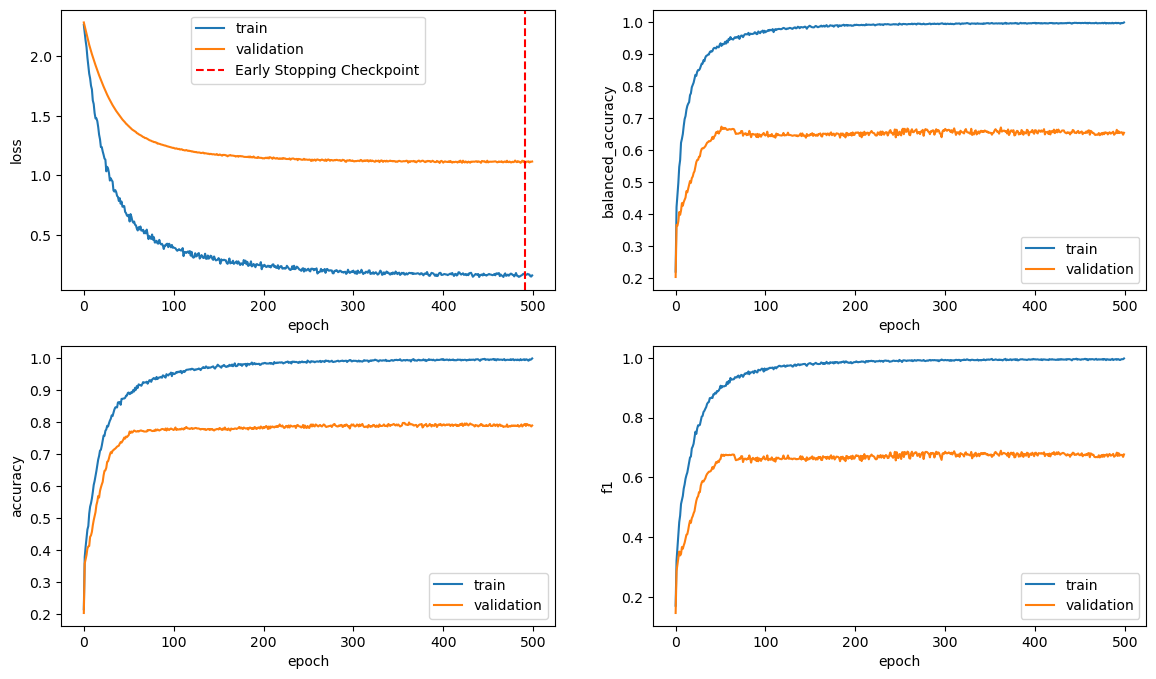

In [16]:
plot_model_training(train_scores_fnn, valid_scores_fnn)

## Performance comparison: CNN vs FNN

In [17]:
y_pred_cnn, y_cnn = get_model_predictions_and_y(model_cnn, valid_dataloader)
y_pred_fnn, y_fnn = get_model_predictions_and_y(model_fnn, valid_dataloader)

### CNN

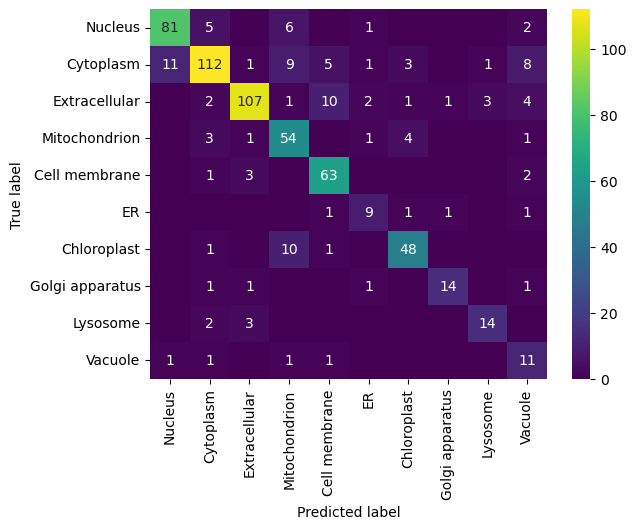

In [18]:
plot_confusion_matrix(model_cnn, X_valid_tensor, y_valid)

In [19]:
print(classification_report(y_valid, y_pred_cnn, target_names=classes))

                 precision    recall  f1-score   support

        Nucleus       0.87      0.85      0.86        95
      Cytoplasm       0.88      0.74      0.80       151
  Extracellular       0.92      0.82      0.87       131
  Mitochondrion       0.67      0.84      0.74        64
  Cell membrane       0.78      0.91      0.84        69
             ER       0.60      0.69      0.64        13
    Chloroplast       0.84      0.80      0.82        60
Golgi apparatus       0.88      0.78      0.82        18
       Lysosome       0.78      0.74      0.76        19
        Vacuole       0.37      0.73      0.49        15

       accuracy                           0.81       635
      macro avg       0.76      0.79      0.76       635
   weighted avg       0.83      0.81      0.81       635



### FNN

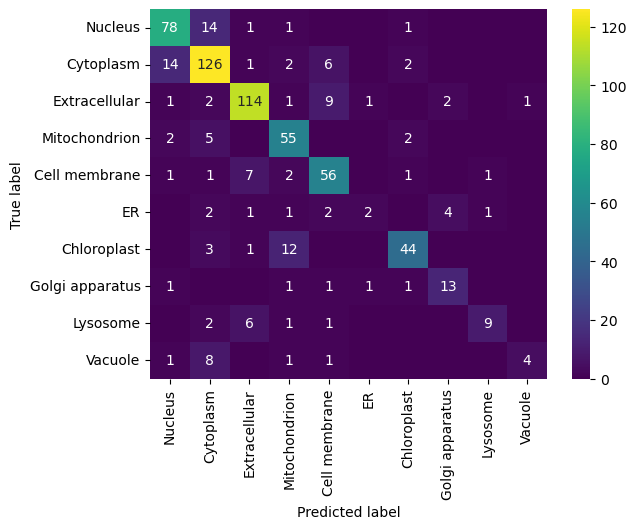

In [20]:
plot_confusion_matrix(model_fnn, X_valid_tensor, y_valid)

In [21]:
print(classification_report(y_valid, y_pred_fnn, target_names=classes))

                 precision    recall  f1-score   support

        Nucleus       0.80      0.82      0.81        95
      Cytoplasm       0.77      0.83      0.80       151
  Extracellular       0.87      0.87      0.87       131
  Mitochondrion       0.71      0.86      0.78        64
  Cell membrane       0.74      0.81      0.77        69
             ER       0.50      0.15      0.24        13
    Chloroplast       0.86      0.73      0.79        60
Golgi apparatus       0.68      0.72      0.70        18
       Lysosome       0.82      0.47      0.60        19
        Vacuole       0.80      0.27      0.40        15

       accuracy                           0.79       635
      macro avg       0.76      0.65      0.68       635
   weighted avg       0.79      0.79      0.78       635



## Accuracy comparison

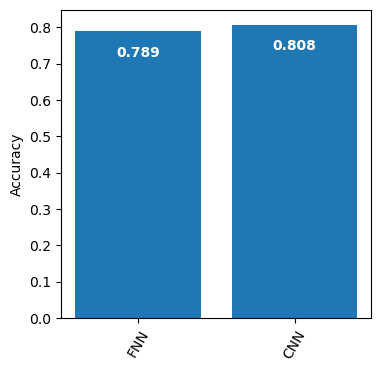

In [23]:
## other way of computing accuracy
# from sklearn.metrics import confusion_matrix
# cm_fnn = confusion_matrix(y_valid, y_pred_fnn)
# accuracy_fnn = np.trace(cm_fnn) / np.sum(cm_fnn)

accuracy_cnn = get_additional_scores(y_pred_cnn, y_cnn)['accuracy']
accuracy_fnn = get_additional_scores(y_pred_fnn, y_fnn)['accuracy']

## plot accuracy 
plot_accuracy(accuracy=[accuracy_fnn, accuracy_cnn],
              xlabel=['FNN','CNN'],
              ylabel='Accuracy', title='')

### Balanced accuracy comparison

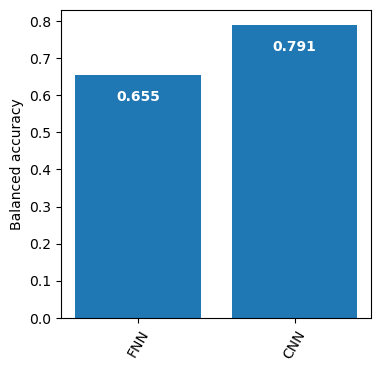

In [24]:
## compute balanced accuracy over subcellular localizations (classes)

balanced_accuracy_cnn = get_additional_scores(y_pred_cnn, y_cnn)['balanced_accuracy']
balanced_accuracy_fnn = get_additional_scores(y_pred_fnn, y_fnn)['balanced_accuracy']

## plot accuracy
## note: p -> padding and s -> stride 
plot_accuracy(accuracy=[balanced_accuracy_fnn, balanced_accuracy_cnn],
              xlabel=['FNN','CNN'],
              ylabel='Balanced accuracy', title='')

## Conclusions and considerations

- CNN slightly outperforms FNN, but at a much higher computational cost: CNN took 12min while FNN took 10sec in current configuration
- Increasing the number of output channels (i.e. feature maps) boosts CNN performance, but at the cost of increased training time. For instance, a CNN with 80 output channels yielded an accuracy of around 0.82 after roughly 40 minutes of training (data not shown).
<!-- - CNN performances have shown larger variation of accuracy in response to changes in Adam's learning rate compared to the FNN ones. -->